In [36]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


## Preprocessing

In [39]:
data = pd.read_csv('dataset.csv')
columns_to_drop = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'time_signature', 'track_genre']
data_cleaned = data.drop(columns=columns_to_drop)

# Label encode binary columns 'explicit' and 'mode'
label_encoder = LabelEncoder()
data_cleaned['explicit'] = label_encoder.fit_transform(data_cleaned['explicit'])

# One-hot encode 'key' column
data_encoded = pd.get_dummies(data_cleaned, columns=['key'], drop_first=True)

# Scale numerical features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data_encoded.drop(columns='popularity'))
data_scaled_encoded = pd.DataFrame(scaled_features, columns=data_encoded.drop(columns='popularity').columns)
data_scaled_encoded['popularity'] = data_encoded['popularity']

# train and test sets
X_encoded = data_scaled_encoded.drop(columns='popularity')
y_encoded = data_scaled_encoded['popularity']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


## Baselines

Mean baseline

In [59]:
y_pred_mean = np.full(y_test.shape, y_train.mean())
rmse_mean_baseline = mean_squared_error(y_test, y_pred_mean, squared=False)
print(f"Root Mean Squared Error (RMSE) for Mean Baseline: {rmse_mean_baseline}")

Root Mean Squared Error (RMSE) for Mean Baseline: 22.21547857312369


Linear Regression baseline

In [60]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse_lr}")

Root Mean Squared Error (RMSE) for Linear Regression: 21.956048140411614


## Random Forest

Train:

In [13]:
rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}")

Root Mean Squared Error (RMSE) for Random Forest: 14.92529789497054


Tune:

In [14]:
param_dist = {
    'n_estimators': np.arange(50, 150, 25),
    'max_features': ['sqrt'],
    'max_depth': np.arange(10, 30, 5).tolist() + [None],
    'min_samples_split': np.arange(5, 50, 5),
    'min_samples_leaf': np.arange(5, 50, 5)
}

# Random search for parameter tuning
n_iter_search = 50  # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, n_iter=n_iter_search, cv=3, n_jobs=-1, verbose=2, random_state=42, error_score='raise') # Added error_score='raise' to raise exceptions
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_params_random

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 50,
 'min_samples_split': 20,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'max_depth': None}

Train with tuned parameters:

In [16]:
best_params_random = {'n_estimators': 140,
    'min_samples_split': 13,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 37} 
best_rf_regressor = RandomForestRegressor(**best_params_random, random_state=42)
best_rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}")

Root Mean Squared Error (RMSE) for Random Forest: 14.92529789497054


Random Forest seems more promising than the NN. Let's try to optimize the Random Forest model.

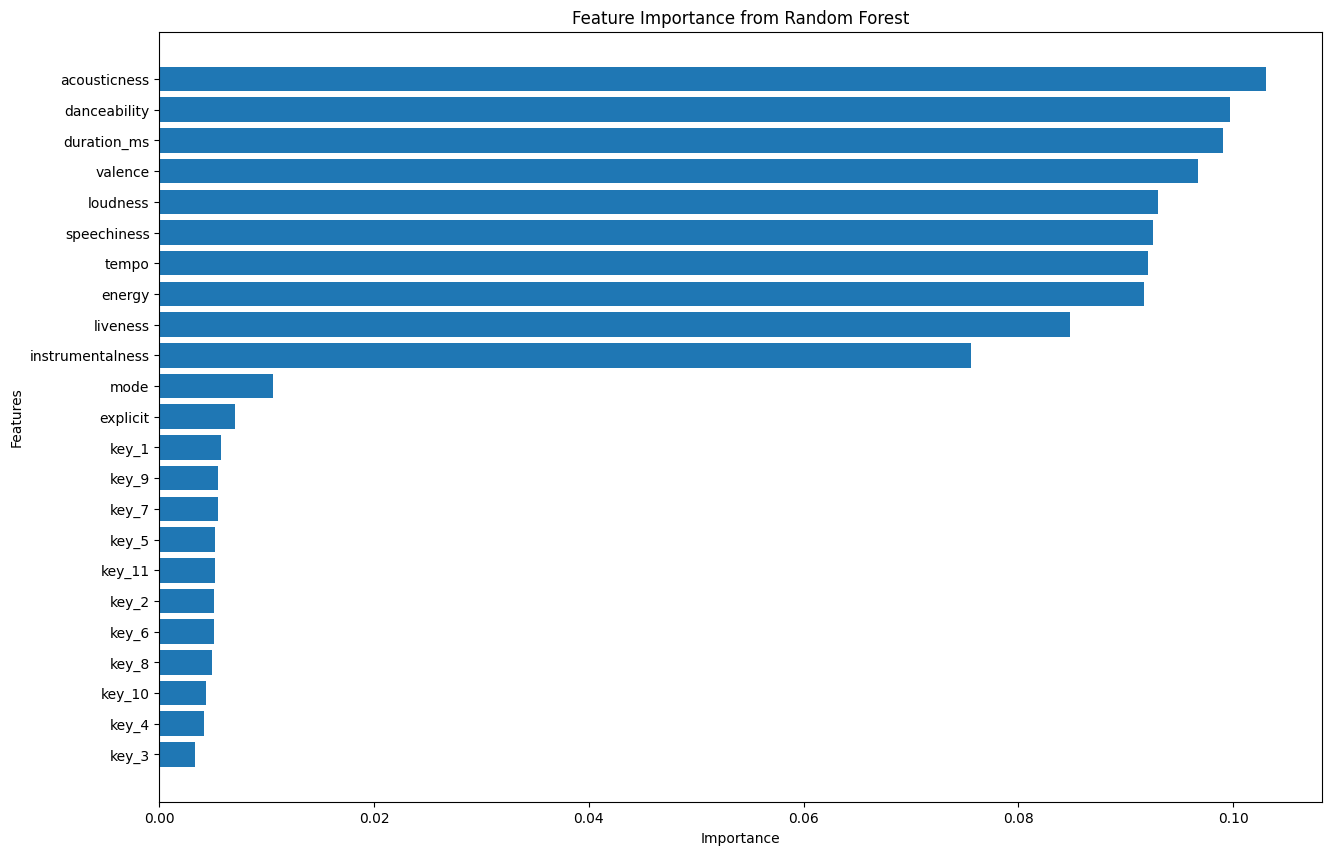

In [21]:
import matplotlib.pyplot as plt

# Extract feature importances
importances = best_rf_regressor.feature_importances_

# Map feature importances to their corresponding feature names
features = X_train.columns
feature_importance_dict = dict(zip(features, importances))

# Sort the features based on importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Visualize the feature importances
plt.figure(figsize=(15, 10))
plt.barh([item[0] for item in sorted_feature_importance], [item[1] for item in sorted_feature_importance])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


Random Forest with only the top 5 features

In [22]:
selected_features = ['acousticness', 'danceability', 'valence', 'loudness', 'speechiness']
X_selected = X_encoded[selected_features]
y_selected = y_encoded
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)


In [23]:
best_rf_regressor_selected = RandomForestRegressor(**best_params_random, random_state=42)
best_rf_regressor_selected.fit(X_train_selected, y_train_selected)


RandomForestRegressor(max_depth=37, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=13, n_estimators=140, random_state=42)

In [24]:
y_pred_rf_selected = best_rf_regressor_selected.predict(X_test_selected)
rmse_rf_selected = mean_squared_error(y_test_selected, y_pred_rf_selected, squared=False)
print(f"Root Mean Squared Error (RMSE) for Random Forest with Selected Features: {rmse_rf_selected}")

Root Mean Squared Error (RMSE) for Random Forest with Selected Features: 17.20156012811089


# Nueral Network

In [20]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_encoded, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=1)
rmse_nn = tf.sqrt(test_loss).numpy()
print(f"Root Mean Squared Error (RMSE) for Neural Network: {rmse_nn}")


Epoch 1/50
2280/2280 [==============================] - 3s 1ms/step - loss: 542.1170 - val_loss: 481.7410
Epoch 2/50
2280/2280 [==============================] - 2s 969us/step - loss: 507.3279 - val_loss: 478.2152
Epoch 3/50
2280/2280 [==============================] - 2s 991us/step - loss: 500.1626 - val_loss: 475.5309
Epoch 4/50
2280/2280 [==============================] - 2s 993us/step - loss: 497.3616 - val_loss: 475.3678
Epoch 5/50
2280/2280 [==============================] - 2s 989us/step - loss: 494.3536 - val_loss: 472.5401
Epoch 6/50
2280/2280 [==============================] - 2s 981us/step - loss: 492.4347 - val_loss: 472.0228
Epoch 7/50
2280/2280 [==============================] - 2s 985us/step - loss: 489.5250 - val_loss: 469.5564
Epoch 8/50
2280/2280 [==============================] - 2s 975us/step - loss: 487.3157 - val_loss: 468.4379
Epoch 9/50
2280/2280 [==============================] - 2s 999us/step - loss: 484.7034 - val_loss: 469.2711
Epoch 10/50
2280/2280 [=======

# Gradient Boosting Machine 

Train:

In [43]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_regressor.fit(X_train, y_train)
y_pred_xgb = xgb_regressor.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"Root Mean Squared Error (RMSE) for XGBoost: {rmse_xgb}")


Root Mean Squared Error (RMSE) for XGBoost: 19.18330540964882


Tune:

In [44]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror')
random_search_xgb = RandomizedSearchCV(xgb_regressor, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=2, random_state=42)
random_search_xgb.fit(X_train, y_train)
best_params_xgb = random_search_xgb.best_params_
print("Best hyperparameters for XGBoost:")
print(best_params_xgb)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters for XGBoost:
{'subsample': 0.8, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.9}


Train with tuned parameters:

In [45]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(**best_params_xgb, objective ='reg:squarederror')
xgb_regressor.fit(X_train, y_train)
y_pred_xgb = xgb_regressor.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"Root Mean Squared Error (RMSE) for XGBoost: {rmse_xgb}")

Root Mean Squared Error (RMSE) for XGBoost: 16.444261329056122


# Gradient Boosting Regressor

Train:

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

y_pred_gb = gb_regressor.predict(X_test)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
print(f"Root Mean Squared Error (RMSE) for Gradient Boosting with Default Parameters: {rmse_gb}")

Root Mean Squared Error (RMSE) for Gradient Boosting with Default Parameters: 21.18594869313061


Tune:

In [47]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
param_dist_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}
random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(random_state=42),
                                     param_distributions=param_dist_gb,
                                     n_iter=50,
                                     scoring='neg_mean_squared_error',
                                     n_jobs=-1,
                                     cv=5,
                                     verbose=2,
                                     random_state=42)

random_search_gb.fit(X_train, y_train)
best_params_gb = random_search_gb.best_params_
print("Best hyperparameters for Gradient Boosting:")
print(best_params_gb)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 150, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.5}


Train with tuned parameters:

In [48]:
best_gb_regressor = GradientBoostingRegressor(**best_params_gb, random_state=42)
best_gb_regressor.fit(X_train, y_train)
y_pred_best_gb = best_gb_regressor.predict(X_test)
rmse_best_gb = mean_squared_error(y_test, y_pred_best_gb, squared=False)
print(f"Root Mean Squared Error (RMSE) for Gradient Boosting with Best Hyperparameters: {rmse_best_gb}")

Root Mean Squared Error (RMSE) for Gradient Boosting with Best Hyperparameters: 17.902608079588358


# SVM

Train:

In [49]:
from sklearn.svm import SVR
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f"Root Mean Squared Error (RMSE) for SVR with Default Parameters: {rmse_svr}")

Root Mean Squared Error (RMSE) for SVR with Default Parameters: 21.673287292217935


Tune:

In [50]:
param_dist_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'epsilon': [0.01, 0.1, 1]
}
random_search_svr = RandomizedSearchCV(SVR(),
                                       param_distributions=param_dist_svr,
                                       n_iter=50,
                                       scoring='neg_mean_squared_error',
                                       n_jobs=-1,
                                       cv=5,
                                       verbose=2,
                                       random_state=42)

random_search_svr.fit(X_train, y_train)
best_params_svr = random_search_svr.best_params_
print("Best hyperparameters for SVR:")
print(best_params_svr)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters for SVR:
{'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.01, 'C': 100}


Train with tuned parameters:

In [51]:
best_svr_regressor = SVR(**best_params_svr)
best_svr_regressor.fit(X_train, y_train)

y_pred_best_svr = best_svr_regressor.predict(X_test)
rmse_best_svr = mean_squared_error(y_test, y_pred_best_svr, squared=False)
print(f"Root Mean Squared Error (RMSE) for SVR with Best Hyperparameters: {rmse_best_svr}")

Root Mean Squared Error (RMSE) for SVR with Best Hyperparameters: 21.107404343540065


# Bagging regressor

Train:

In [52]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
bagging_regressor.fit(X_train, y_train)

y_pred_bagging = bagging_regressor.predict(X_test)
rmse_bagging = mean_squared_error(y_test, y_pred_bagging, squared=False)
print(f"Root Mean Squared Error (RMSE) for Bagging Regressor with Default Parameters: {rmse_bagging}")

c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Root Mean Squared Error (RMSE) for Bagging Regressor with Default Parameters: 15.666700385865326


Tune and then train:

In [58]:
tree_params = {
    'max_depth': best_params_bagging.pop('base_estimator__max_depth', None),
    'min_samples_split': best_params_bagging.pop('base_estimator__min_samples_split', 2),
    'min_samples_leaf': best_params_bagging.pop('base_estimator__min_samples_leaf', 1)
}
tree_regressor = DecisionTreeRegressor(**tree_params)
best_bagging_regressor = BaggingRegressor(base_estimator=tree_regressor, **best_params_bagging, random_state=42)
best_bagging_regressor.fit(X_train, y_train)

y_pred_best_bagging = best_bagging_regressor.predict(X_test)
rmse_best_bagging = mean_squared_error(y_test, y_pred_best_bagging, squared=False)
print(f"Root Mean Squared Error (RMSE) for Bagging Regressor with Best Hyperparameters: {rmse_best_bagging}")

c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Root Mean Squared Error (RMSE) for Bagging Regressor with Best Hyperparameters: 15.028043220145463
